In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs109b_hw2.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 

## Homework 2: Bayesian Analysis



**Harvard University**<br/>
**Spring 2024**<br/>
**Instructors**: Pavlos Protopapas & Alex Young


<hr style="height:2pt">

In [2]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/"
    "content/styles/cs109.css"
).text
HTML(styles)

<div style = "background: lightsalmon; border: thin solid black; border-radius: 2px; padding: 5px">

### Instructions
- To submit your notebook, follow the instructions given in on the Canvas assignment page.
- Plots should be legible and interpretable *without having to refer to the code that generated them*. They should includelabels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you believe the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so simply passing all tests may not be sufficient for full credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output.
- Feel free to add additional code or markdown cells as needed.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**
</div>

In [3]:
import time
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy.special import expit
from scipy.stats import bernoulli, norm
from scipy.stats import mode
from sklearn.metrics import accuracy_score

In [4]:
# measure notebook runtime
time_start = time.time()

## Notebook Contents
<a id="contents"></a>
- **Dataset Information**
- **Bayesian Logistic Regression with Varying-Intercept Description**
- [**Part 1: Varying-Intercept Model (Simulated Response Variable)**](#part1)
- [**Part 2: Varying-Intercept Model (Real Data)**](#part2)
- [**Part 3: Varying-Coefficients Model**](#part3)
- [**Part 4: Prediction & Model Selection**](#part4)

## Dataset Information

### Contraceptive Usage by Bangladeshi Women

For this assignment, you are provided with datasets `train.csv` and `test.csv` which contain details of contraceptive usage among 1,934 Bangladeshi women.

There are four attributes for each woman along with a response variable, `contraceptive_use`, indicating if she uses contraceptives. The four attributes include:

* `district`: code identifying the district in which the woman lives (60 districts in total)
* `urban`: type of region of residence (binary)
* `living.children`: number of living children
* `age-mean`: age of the woman (in years, centered around mean)

The task is to build a classification model that can predict if a given woman uses contraceptives.

The following cell will load and inspect the train and test datasets.

TRAINING DATA INFO:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   district           967 non-null    int64  
 1   urban              967 non-null    int64  
 2   living.children    967 non-null    int64  
 3   age_mean           967 non-null    float64
 4   contraceptive_use  967 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 37.9 KB

TEST DATA INFO:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   district           967 non-null    int64  
 1   urban              967 non-null    int64  
 2   living.children    967 non-null    int64  
 3   age_mean           967 non-null    float64
 4   contraceptive_use  967 non-null    int64  
dtypes: float64(1), int64(4)
m

district  urban  living.children  age_mean  contraceptive_use
0        35      0                4    2.4400                  0
1        22      0                2   -1.5599                  1
2        29      0                2   -8.5599                  1

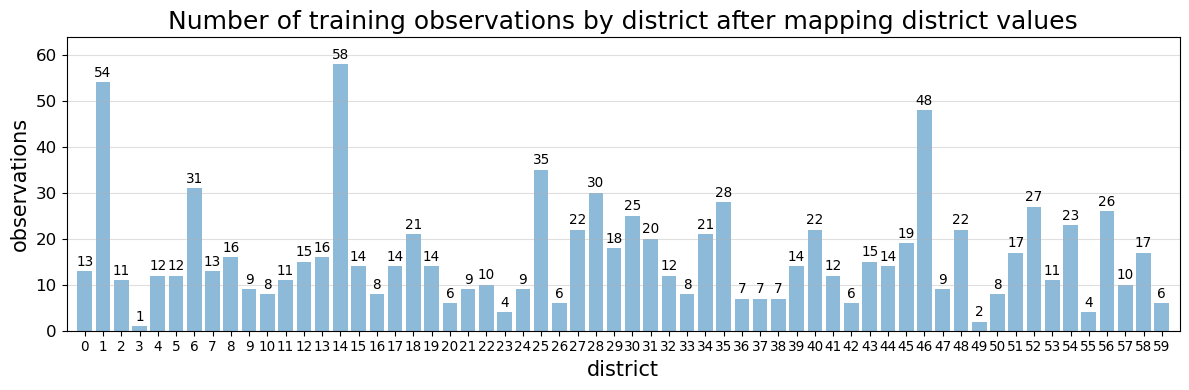

In [5]:
# loading and inspecting the data
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

# print dataset summary info for ease of reference
print("TRAINING DATA INFO:\n")
df_train.info()
print("\nTEST DATA INFO:\n")
df_test.info()
print("\nTRAINING DATA SUMMARY STATS:\n")
print(df_train.describe())
print("\nTRAINING DATA FIRST ROWS OF DATA:")
display(df_train.head(3))
print()

# And plot observation counts by district also just for reference
def plot_value_counts(value_counts, var_name, font_perc):
    """Generates barplot from pandas value_counts series"""
    fig, ax = plt.subplots(figsize=(12, 4))

    max_y = max(value_counts.values)
    n_cats = len(value_counts)

    ax.bar(range(n_cats), value_counts.values, alpha=0.5)

    for x, y in enumerate(value_counts):
        ax.text(
            x, y+max_y*.02,
            "{:,}".format(y),
            color="k",
            fontsize=14*font_perc,
            horizontalalignment="center"
        ) 

    ax.set_title(
        "Number of training observations by {} after mapping district values".format(
            var_name
        ),
        fontsize=18
    )
    ax.set_xlabel("{}".format(var_name), fontsize=15)
    ax.set_ylabel("observations", fontsize=15)
    ax.set_xticks(range(n_cats))
    ax.set_xticklabels(value_counts.index)
    ax.tick_params("x", labelsize=14*font_perc)
    ax.tick_params("y", labelsize=12)
    ax.set_ylim(top=max_y+(max_y*.1))

    ax.grid(":", axis="y", alpha=0.4)
    ax.margins(x=.01)
    plt.tight_layout()
    plt.show();

# plot and print summary of resulting district values
dist_counts = df_train["district"].value_counts().sort_index()

plot_value_counts(dist_counts, "district", .7)



## Bayesian Logistic Regression with Varying-Intercept Description


The first model we'd like to fit to the contraceptives data will be a **varying-intercept logistic regression** model, where the model's intercept varies by district.

Prior distributions:

$$
\begin{split}
\beta_{0j} &\sim N(\mu_0,\sigma_0^2)\; \text{, with} \;\; \mu_0 \sim N(0,10000)\; \text{and} \; \; \frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)
\\
\beta_1 &\sim N(0,10000) 
\\ \\ 
\beta_2 &\sim N(0,10000)
\\ \\ 
\beta_3 &\sim N(0,10000)
\\ \\
\end{split}
$$

Model for data:

$$
\begin{split}
Y_{ij} & \sim \text{Bernoulli}(p_{ij})
\\ \\
\text{logit}\:p_{ij} &= \beta_{0j} + \beta_1 \times \text{urban} + \beta_2 \times \text{living.children} + \beta_3 \times \text{age-mean}
\\ \\
\end{split}
$$

Where $Y_{ij}$ is 1 if woman $i$ in district $j$ uses contraceptives, and 0 otherwise, and where $i \in \{1,...,N\}$ and $j \in \{1,...,J\}$. $N$ is the number of observations in the data, and $J$ is the number of districts. The above notation assumes $N(\mu, \sigma^2)$ is a Normal distribution with mean $\mu$ and variance $\sigma^2$.

**PLEASE NOTE:** The $\text{Gamma}$ distribution cited above, uses the $\text{Gamma}(\alpha, \beta)$ parametrization, where $\alpha$ is the shape and $\beta$ is the rate.  

<a id="part1"></a>

### <div class='exercise'>Part 1: Varying-Intercept Model (Simulated Response Variable)</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.1 - Simulate Response</b></div>

To verify that PyMC can indeed recover the hidden parameter values, we'll simulate values of the response variable, `contraceptive_use`, for observations in the training set using the 4 predictors and *hard-coded model parameters of our choosing*. Then, using this simulated data, we'll check if PyMC can get back the parameter values that we hard-coded. If it does, we'll have some reason to believe that it can recover the hidden parameter values that generated the *real* data.

**Note: Synthetic response values generated using the parameters below will only be used in question 1.1 - 1.4**.

Generate $Y$ using the training data and the following hard-coded values:

$$
\begin{split}
\mu_0 &= 2
\\ \\
\sigma^2_0 &= 1
\\ \\
\beta_{0j} &\sim N(\mu_0,\sigma_0^2) \; \text{for all sixty districts}
\\ \\
\beta_1 &= 4
\\ \\ 
\beta_2 &= -3
\\ \\
\beta_3 &= -2
\\ \\
\end{split}
$$

Save your simulated values in a numpy array called `simulated_Y`.

**Verify that these parameters generate data in which an average of 46% to 49% of subjects use contraceptives.**

In [6]:
# set seed for consistency across runs
np.random.seed(109)
# your code here
mu_0 = 2
sigma_0 = 1  # Standard deviation, sqrt(variance)
beta_1 = 4
beta_2 = -3
beta_3 = -2

# Unique districts
districts = df_train['district'].unique()
# Simulate beta_0j for each district
beta_0j_dict = {district: norm.rvs(mu_0, sigma_0) for district in districts}

# Calculate linear combination for each observation
linear_combination = df_train.apply(lambda row: beta_0j_dict[row['district']] + 
                                    beta_1 * row['urban'] + 
                                    beta_2 * row['living.children'] + 
                                    beta_3 * row['age_mean'], axis=1)

# Convert linear combination to probabilities using logistic function
probabilities = 1 / (1 + np.exp(-linear_combination))

# Simulate contraceptive use using a Bernoulli distribution with calculated probabilities
simulated_Y = bernoulli.rvs(probabilities)

# Replace the simulated values in the dataframe
df_train['simulated_contraceptive_use'] = simulated_Y

# Calculate and print the average percentage of subjects using contraceptives
average_percentage = simulated_Y.mean() * 100
average_percentage

48.3971044467425

In [7]:
grader.check("q1.1")

q1.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.2 - Fit Varying-Intercept Model (Simulated Data)</b></div>

Create and fit the varying-intercept model specified above to your simulated data. Reasonably good convergence may require adjustments to the number of tuning samples and the target acceptance rate as suggested by any warnings from PyMC.

In [8]:
# your code here
districts = df_train['district'].astype('category').cat.codes.values
n_districts = len(np.unique(districts))
urban = df_train['urban'].values
living_children = df_train['living.children'].values
age_mean = df_train['age_mean'].values
y_sim = df_train['simulated_contraceptive_use'].values

with pm.Model() as varying_intercept_model1:
    # Priors
    mu_alpha = pm.Normal("mu_alpha", mu=0, sigma=1)
    alpha = pm.Normal("alpha", mu=mu_alpha, shape=n_districts)
    beta1 = pm.Normal("beta1", mu=0, sigma=10000)
    beta2 = pm.Normal("beta2", mu=0, sigma=10000)
    beta3 = pm.Normal("beta3", mu=0, sigma=10000)
    
    eta = alpha[districts] + beta1 * urban + beta2 * living_children + beta3 * age_mean
    p = pm.Deterministic("p", pm.math.sigmoid(eta))
    
    y = pm.Bernoulli("y", p=p, observed=y_sim)



<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.3 - Convergence Diagnostics</b></div>

Plot the trace plots of the MCMC sampler for the parameters $\mu_0, \frac{1}{\sigma^2_0}\text{ (a.k.a., }\tau_0\text{)}, \beta_1, \beta_2, \beta_3$. Based on these and the R-hat values, does it look like the samplers converged? Explain your reasoning.


**Hint:** Use the Arviz `plot_trace()` function

The second image contains the trace plots for the MCMC sampler's parameters. Each row corresponds to a parameter, with the left column showing the posterior distribution and the right column showing the trace over sampling iterations.
- mu_alpha: The posterior distribution looks normally distributed, and the trace plot shows good mixing, suggesting convergence.
- alpha: The plot shows that there are multiple lines, one for each district's intercept. The traces are dense and overlapping, suggesting that the chains are exploring the parameter space well.
- beta1, beta2, beta3: The posterior distributions for these coefficients are normally distributed, and their trace plots indicate good mixing.
- The trace plot for p shows a dense plot because it's a deterministic transformation of other variables and there are many observations.

Based on the trace plots alone:
- Good mixing is indicated by the "hairy caterpillar" appearance of the traces.
- The stationary distribution of the trace plots suggests that the Markov chains have likely converged to the target posterior distribution

Overall, with most of the R-hat values close to 1, reasonable effective sample sizes, and low Monte Carlo standard errors suggest that the MCMC sampler has likely converged for these parameters. 

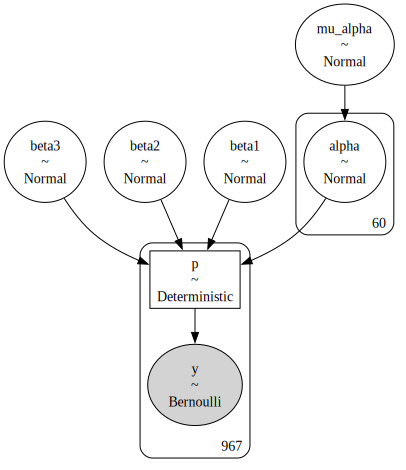

In [9]:
pm.model_to_graphviz(varying_intercept_model1)

In [10]:
with varying_intercept_model1:
    trace1 = pm.sample(1000, tune=2000, target_accept=0.95) 
    print(f'DONE')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_alpha, alpha, beta1, beta2, beta3]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 17 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 2733 divergences after tuning. Increase `target_accept` or reparameterize.


DONE


In [11]:
summary_df = pm.summary(trace1)
summary_df

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_alpha  1.151  0.637  -0.019    2.390      0.069    0.049      86.0   
alpha[0]  0.938  1.130  -1.276    3.016      0.071    0.050     254.0   
alpha[1]  0.594  1.041  -1.180    2.651      0.073    0.051     206.0   
alpha[2]  1.164  1.163  -0.938    3.357      0.066    0.046     315.0   
alpha[3]  1.227  1.161  -0.906    3.423      0.078    0.055     219.0   
...         ...    ...     ...      ...        ...      ...       ...   
p[962]    1.000  0.000   1.000    1.000      0.000    0.000     892.0   
p[963]    0.992  0.011   0.975    1.000      0.000    0.000     970.0   
p[964]    0.998  0.003   0.995    1.000      0.000    0.000    1094.0   
p[965]    0.000  0.000   0.000    0.000      0.000    0.000     619.0   
p[966]    1.000  0.000   1.000    1.000      0.000    0.000     597.0   

          ess_tail  r_hat  
mu_alpha     184.0   1.05  
alpha[0]     554.0   1.01  
alpha[1]     425.0   1.01  
alpha[2]     709.0   1.01  
alpha[3]     647.0   1.01  
...            ...    ...  
p[962]      1236.0   1.01  
p[963]      1026.0   1.01  
p[964]      1608.0   1.00  
p[965]       562.0   1.02  
p[966]       730.0   1.01  

[1031 rows x 9 columns]

In [12]:
#SHARE WITH R_HAT > 1.1 (if these are too many,then convergence likely not occurring)
summary_df[(summary_df['r_hat'] > 1.1)].shape[0]/len(summary_df)

0.0

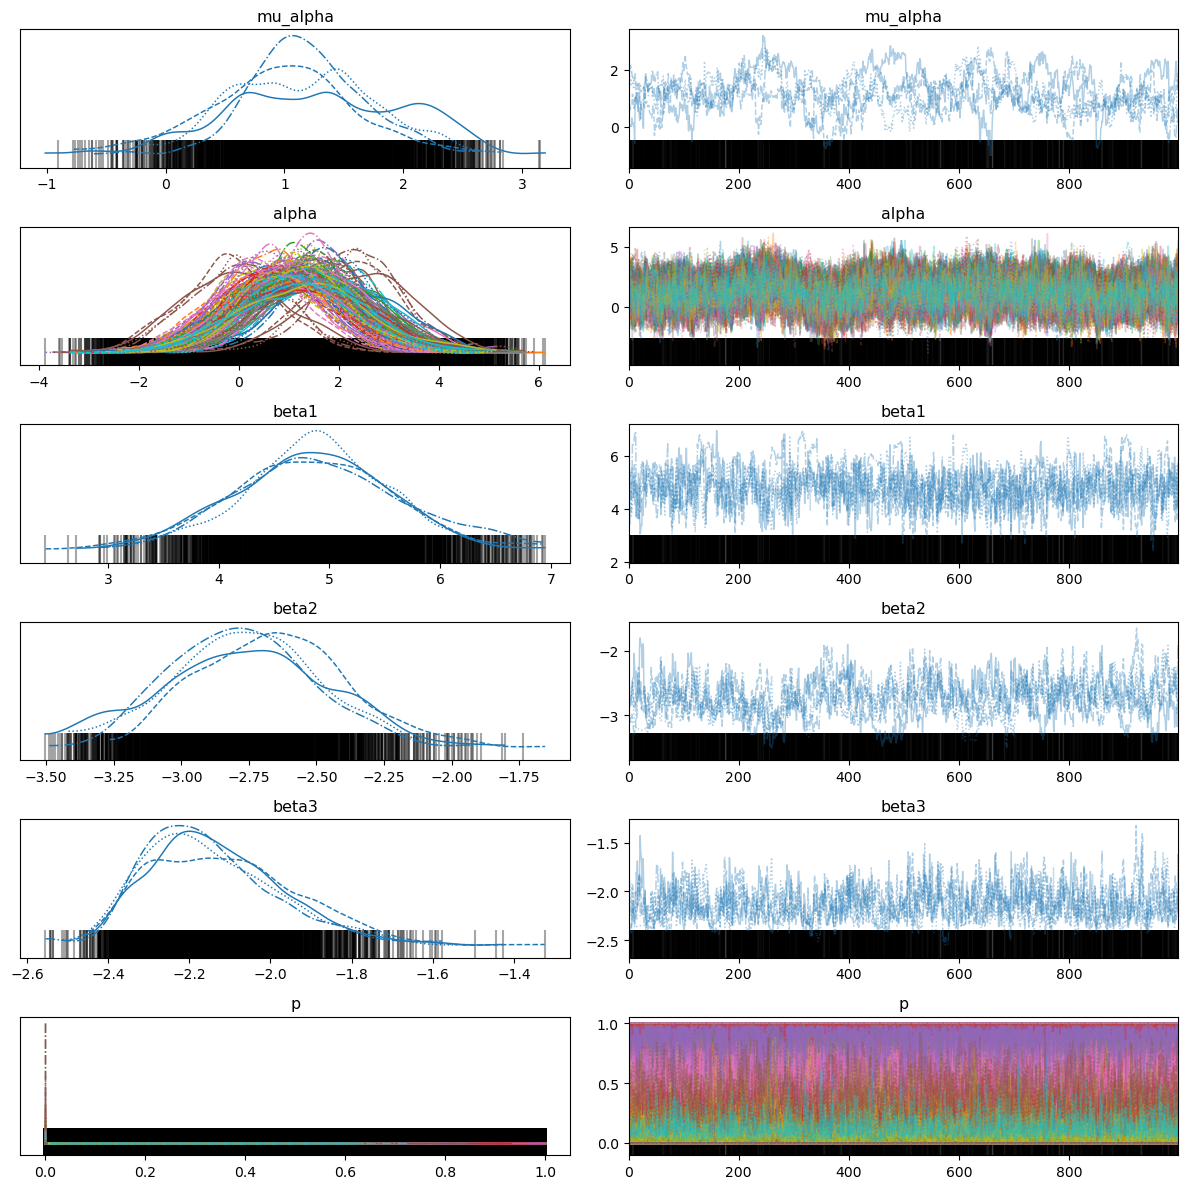

In [13]:
pm.plot_trace(trace1)
plt.tight_layout();

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.4 - Inspecting Posteriors</b></div>

Plot histograms of the posterior distributions for the parameters $\beta_{0,9}$, $\beta_{0,19}$, $\beta_{0,29}$, ..., $\beta_{0,59}$. Are the actual parameters that you generated contained within these posterior distributions?

**Hint: The `az.plot_posterior()` function might be helpful here.**

The beta values correspond to the true, simulated varying intercepts for districts 9, 19, 29, 39, 49, and 59, respectively. From the plots below, it seems that the posterior means are within the following ranges of the 94% Highest Density Interval (HDI). 

District 9 (alpha[8]): Posterior mean is around 1.3 with HDI spanning from approximately -0.79 to 3.4. 
District 19 (alpha[18]): Posterior mean is around 1.4 with HDI spanning from approximately -0.54 to 3.3.
And so on for the other districts.

In [14]:
# your code here
[beta_0j_dict[8], beta_0j_dict[18], beta_0j_dict[28], beta_0j_dict[38], beta_0j_dict[48], beta_0j_dict[58]]

[3.4171768553390214,
 1.9690814532421026,
 1.658238372764984,
 3.261321748777321,
 2.3480674310258043,
 1.8223119818656208]

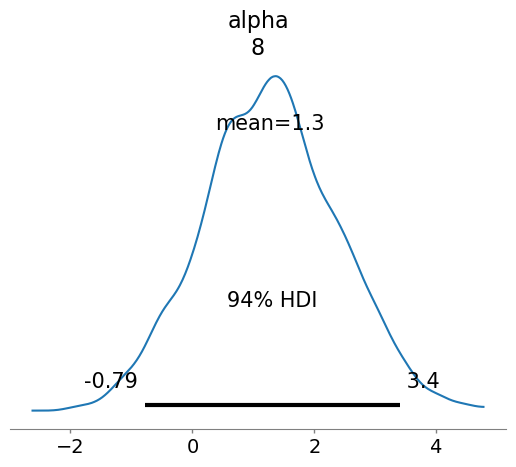

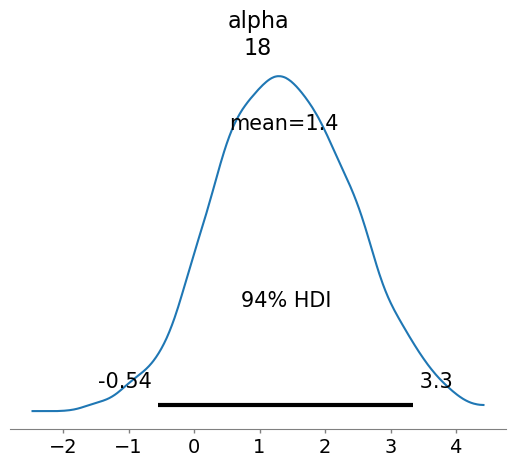

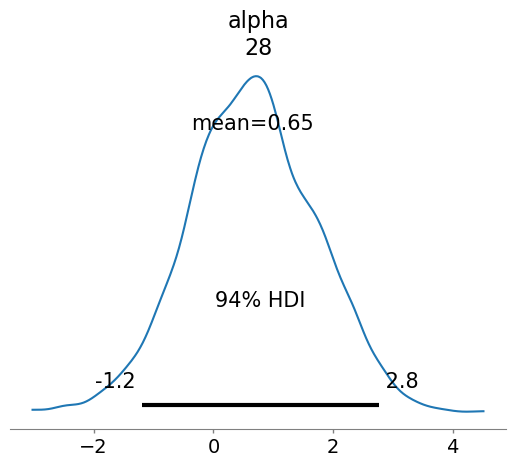

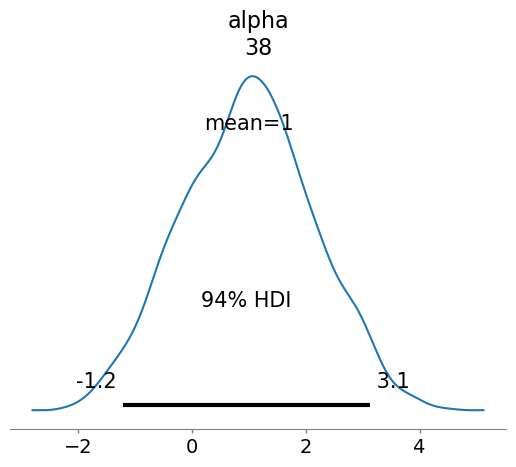

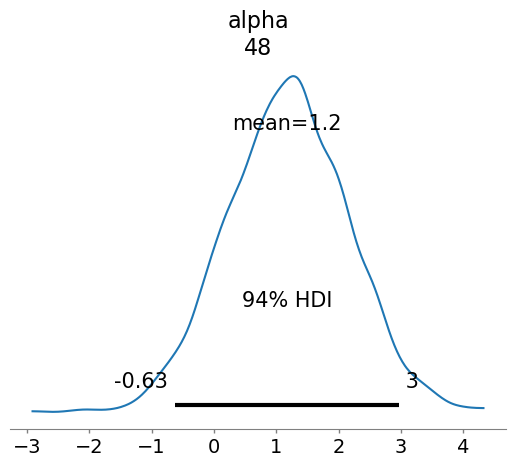

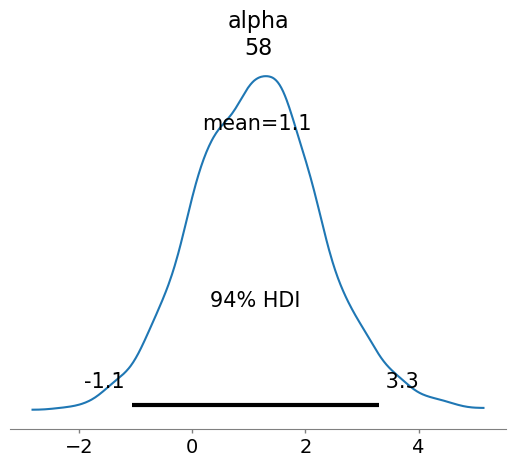

In [15]:
indices = [8, 18, 28, 38, 48, 58]

# plot posterior
for idx in indices:
    az.plot_posterior(trace1, var_names=['alpha'], coords={'alpha_dim_0': [idx]})

<!-- END QUESTION -->

<a id="part2"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

### <div class='exercise'>Part 2: Varying-Intercept Model (Real Data)</div> 

[Return to contents](#contents)


<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.1 - Fit Varying-Intercept Model (Real Data)</b></div>

Now we'll fit our model to the *actual* data. Construct and fit the varying-intercept model to the real training data.

In [16]:
# your code here
y_act = df_train['contraceptive_use'].values

with pm.Model() as varying_intercept_model2:
    mu_0 = pm.Normal('mu_0', mu=0, sigma=10000)
    sigma_0 = pm.InverseGamma('sigma_0', alpha=0.1, beta=0.1)
    alpha = pm.Normal("alpha", mu=mu_0, sigma = sigma_0, shape=n_districts)
    beta1 = pm.Normal("beta1", mu=0, sigma=10000)
    beta2 = pm.Normal("beta2", mu=0, sigma=10000)
    beta3 = pm.Normal("beta3", mu=0, sigma=10000)
    
    eta = alpha[districts] + beta1 * urban + beta2 * living_children + beta3 * age_mean
    p = pm.Deterministic("p", pm.math.sigmoid(eta))
    
    y = pm.Bernoulli("y", p=p, observed=y_act)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.2 - Convergence Diagnostics</b></div>

Check the convergence by examining the trace plots and R-hats, as you did with the simulated data. What do you observe?

Trace Plots:
- For alpha (the varying intercepts for each district), the trace plots seem to display good mixing, with the samples densely covering a range of values and not exhibiting clear trends or drifts.
- For beta1, beta2, and beta3, the plots also show dense sampling without clear trends, suggesting that the chains have explored the parameter space well.
- The plot for p shows many lines because p is a deterministic transformation of the other variables and there are many observations.

All/most r_hat values shown are exactly 1.0, which is a perfect scenario indicating that the chains for these parameters have converged. 
The effective sample sizes (ess_bulk and ess_tail) are very high, in the thousands for alpha and tens to hundreds of thousands for p, which is excellent and indicates that we have a large number of effectively independent samples from the posterior distribution.

Overall, based on the visual inspection of the trace plots and the summary statistics provided, the model appears to have converged well. 

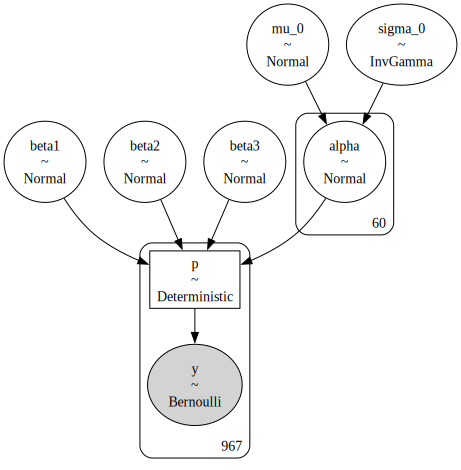

In [17]:
# your code here
pm.model_to_graphviz(varying_intercept_model2)

In [18]:
with varying_intercept_model2:
    trace2 = pm.sample(1000, tune=2000, target_accept=0.95) 
    print(f'DONE')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_0, sigma_0, alpha, beta1, beta2, beta3]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 11 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


DONE


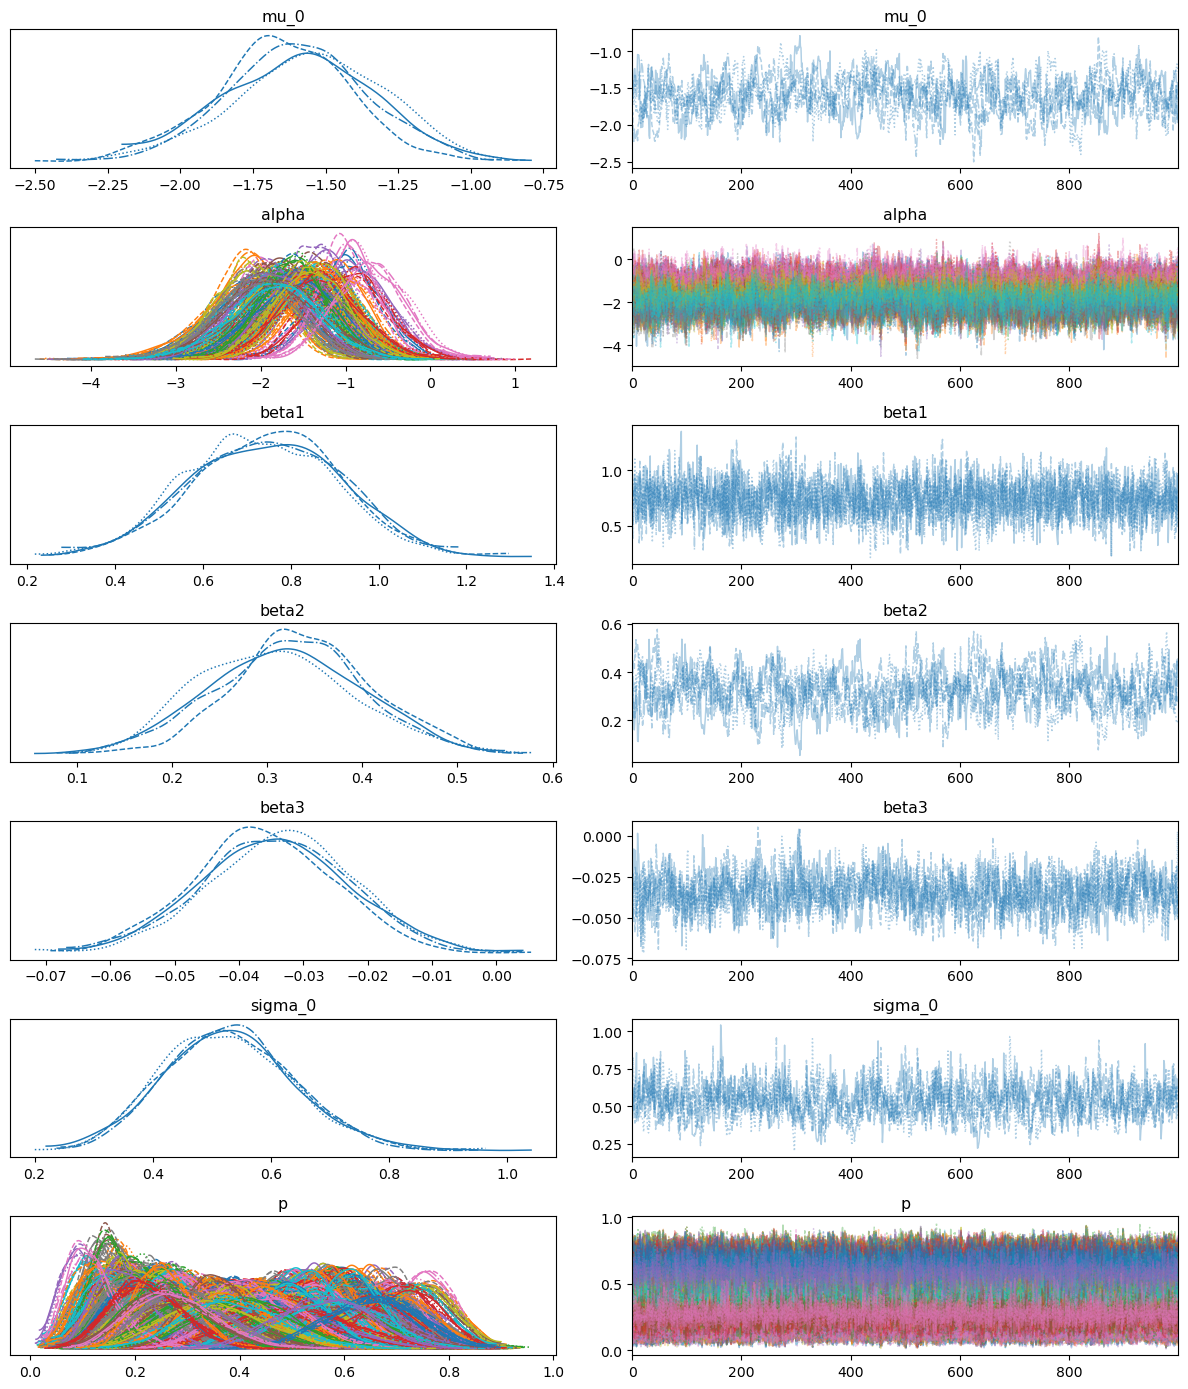

In [19]:
pm.plot_trace(trace2)
plt.tight_layout();

In [20]:
summary_df_2 = pm.summary(trace2)
summary_df_2

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_0     -1.598  0.250  -2.067   -1.122      0.016    0.012     234.0   
alpha[0] -2.072  0.487  -2.946   -1.098      0.018    0.013     745.0   
alpha[1] -2.118  0.375  -2.852   -1.441      0.019    0.014     376.0   
alpha[2] -1.769  0.487  -2.727   -0.896      0.018    0.013     726.0   
alpha[3] -1.495  0.595  -2.617   -0.390      0.018    0.012    1136.0   
...         ...    ...     ...      ...        ...      ...       ...   
p[962]    0.259  0.072   0.123    0.392      0.001    0.001    4223.0   
p[963]    0.222  0.066   0.103    0.345      0.001    0.001    3296.0   
p[964]    0.563  0.088   0.390    0.720      0.002    0.001    1877.0   
p[965]    0.263  0.079   0.116    0.409      0.001    0.001    3414.0   
p[966]    0.275  0.081   0.134    0.429      0.001    0.001    3210.0   

          ess_tail  r_hat  
mu_0         564.0   1.02  
alpha[0]    1745.0   1.01  
alpha[1]    1128.0   1.01  
alpha[2]    1696.0   1.00  
alpha[3]    2129.0   1.00  
...            ...    ...  
p[962]      2662.0   1.00  
p[963]      2434.0   1.00  
p[964]      2528.0   1.00  
p[965]      2628.0   1.00  
p[966]      2683.0   1.00  

[1032 rows x 9 columns]

In [21]:
#SHARE WITH R_HAT > 1.1 (if these are too many,then convergence likely not occurring)
summary_df_2[(summary_df_2['r_hat'] > 1.1)].shape[0]/len(summary_df_2)

0.0

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.3 - Districts with Highest & Lowest Rates of Contraceptive Usage</b></div>

Based on the posterior means, which district has the highest base rate of contraceptive usage (independent of other factors like urban population)? Which district has the lowest? Explain how you arrived at these conclusions, interpreting any numerical values that played a role in your reasoning.

- The highest base rate of contraceptive usage is in District 56, with a mean intercept of 0.83. This suggests that, independent of other factors, District 56 has the highest probability of contraceptive usage among the districts in the study.
-  The lowest base rate is in District 11, with a mean intercept of -1.71. This indicates that, when other factors are at their reference levels, District 11 has the lowest probability of contraceptive usage.

To arrive at the conclusions about which districts have the highest and lowest base rates of contraceptive usage, the following numerical values were used:

- Posterior Means (alpha_posterior_means): These values represent the average effect of each district on the log-odds of contraceptive use, after accounting for the effects of other variables in the model. These means are calculated by averaging the samples from the posterior distribution of each district's intercept, which gives us an estimate of the central tendency for each district's effect.

- Highest Base Rate: The district with the highest base rate of contraceptive usage was identified using np.argmax(alpha_posterior_means).The numerical value associated with the highest base rate is the largest mean intercept value, indicating the strongest positive effect on the log-odds of contraceptive use when other factors are at their reference levels.
- Lowest Base Rate: Similarly, np.argmin(alpha_posterior_means) was used to find the index of the minimum value in the array. The numerical value associated with the lowest base rate is the smallest (most negative) mean intercept value, indicating the strongest negative effect on the log-odds of contraceptive use under the same conditions.

- Interpretation of Log-Odds:

1) The mean intercept values are in log-odds units. Log-odds can be difficult to interpret directly, but they represent the logarithm of the odds of contraceptive usage. A higher log-odds value means higher odds, and hence a higher probability, of contraceptive usage.
2) The district with the highest mean intercept, and therefore the highest log-odds of contraceptive usage, was identified as District 56 with a mean intercept of approximately 0.83. This value, being positive and the highest among the districts, indicates that District 56 has the highest probability of contraceptive use relative to other districts.
3) Conversely, the district with the lowest mean intercept, indicating the lowest log-odds and thus the lowest probability of contraceptive usage, was identified as District 11 with a mean intercept of approximately -1.71. The negative value and its magnitude being the lowest suggests that District 11 has the lowest base rate of contraceptive usage.
=> By comparing these intercept values, we are effectively comparing the base rates of contraceptive usage across districts while controlling for the other variables in the model. This is because the intercepts capture the average propensity for contraceptive use in each district when the other predictors are held constant at their reference or baseline levels.

In [22]:
# your code here
alpha_posterior_means = trace2.posterior['alpha'].mean(dim=['chain', 'draw']).values

highest_base_rate_district = np.argmax(alpha_posterior_means)
lowest_base_rate_district = np.argmin(alpha_posterior_means)

highest_base_rate_value = alpha_posterior_means[highest_base_rate_district]
lowest_base_rate_value = alpha_posterior_means[lowest_base_rate_district]

print(f"District with the highest base rate of contraceptive usage: District {highest_base_rate_district} with a mean intercept of {highest_base_rate_value:.2f}")
print(f"District with the lowest base rate of contraceptive usage: District {lowest_base_rate_district} with a mean intercept of {lowest_base_rate_value:.2f}")


District with the highest base rate of contraceptive usage: District 56 with a mean intercept of -0.70
District with the lowest base rate of contraceptive usage: District 11 with a mean intercept of -2.18


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.4 - Varying Intercept? Conclusions from Posterior Samples</b></div>

What are the posterior means of $\mu_0$ and $\sigma_0$? Do these values offer any evidence in support of or against the varying-intercept model, compared to a model with a single intercept value for all districts? Explain why or why not.


**Hint:** Both ArviZ's `plot_posterior` and [`plot_forest()`](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_forest.html) functions will prove useful here.

The posterior means of $\mu_0$ and $\sigma_0$ are -1.6 and 0.53, respectively. We also know that the 94% HDI for $\mu_0$ is [-2.1,-1.1] and for $\sigma_0$  it is [-0.31, 0.73], statistically different from 0. 

The evidence from the posterior means of μ_0 and σ_0 suggests that the varying-intercept model is appropriate for this data as there is significant variability in contraceptive usage across districts that a single intercept model would not account for. The negative mean value of μ_0 indicates that the overall tendency across districts, without considering other variables, is towards lower contraceptive use rates. The model with varying intercepts is therefore more informative for understanding district-level differences in contraceptive use.


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_0    -1.598  0.250  -2.067   -1.122      0.016    0.012     234.0   
sigma_0  0.530  0.111   0.319    0.733      0.004    0.003     623.0   

         ess_tail  r_hat  
mu_0        564.0   1.02  
sigma_0     902.0   1.00  


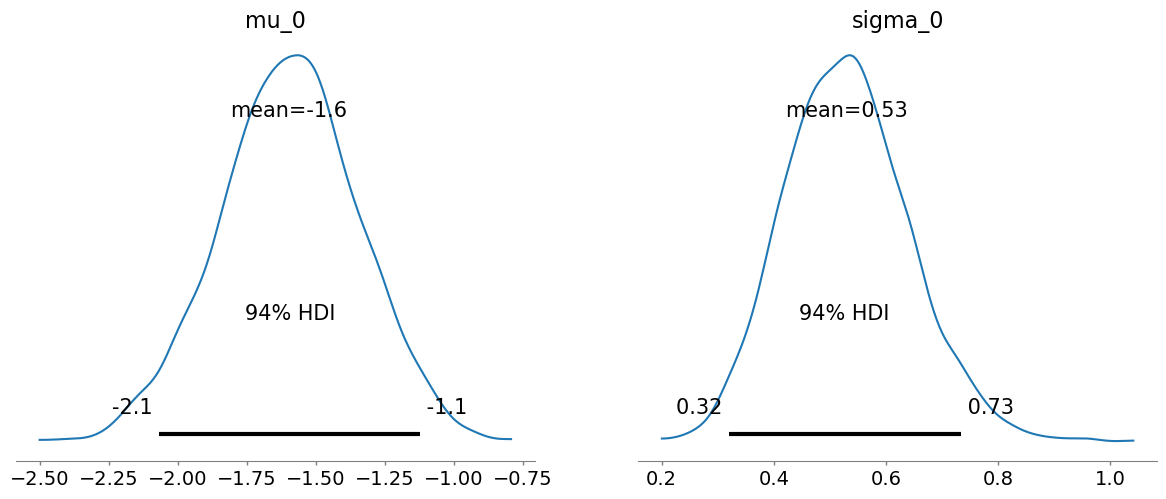

In [23]:
# your code here
# your code here
summary = az.summary(trace2, var_names=['mu_0', 'sigma_0'])
print(summary)
az.plot_posterior(trace2, var_names=['mu_0', 'sigma_0']);

<!-- END QUESTION -->

<a id="part3"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

## <div class='exercise'>Part 3: Varying-Coefficient Model</div> 

[Return to contents](#contents)


The next model we will fit to the contraceptives data is a **varying-coefficients logistic regression** model. Here, in addition to a varying intercept, the coefficients on `living.children`, `age_mean`, and `urban` also vary by district.

Prior distribution:

$$
\begin{split}
\beta_{0j} &\sim N(\mu_0,\sigma_0^2)\; \text{, with} \;\; \mu_0 \sim N(0,10000)\; \text{and} \; \; \frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)
\\
\beta_{1j} &\sim N(0,\sigma_1^2)\; \text{, with} \;\; \frac{1}{\sigma^2_1} \sim \text{Gamma}(0.1,0.1) 
\\
\beta_{2j} &\sim N(0,\sigma_2^2)\; \text{, with} \;\; \frac{1}{\sigma^2_2} \sim \text{Gamma}(0.1,0.1)
\\ 
\beta_{3j} &\sim N(0,\sigma_3^2)\; \text{, with} \;\; \frac{1}{\sigma^2_3} \sim \text{Gamma}(0.1,0.1)
\\
\end{split}
$$

Model for data:

$$
\begin{split}
Y_{ij} &\sim \text{Bernoulli}(p_{ij})
\\ \\
\text{logit}\:p_{ij} &= \beta_{0j} + \beta_{1j} \times \text{urban} + \beta_{2j} \times \text{living.children} + \beta_{3j} \times \text{age-mean}
\\ \\
\end{split}
$$

**PLEASE NOTE:**

* The name "varying coefficient model" is used here to distinguish the Q3 model from the "varying intercept" model in Q2, but observe from the specification about that **BOTH** intercepts *and* coefficients vary in this Q3 model.
* Once again, the $\text{Gamma}$ distribution uses the $\text{Gamma}(\alpha, \beta)$ parametrization, where $\alpha$ is the shape and $\beta$ is the rate. 

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.1 - Fit Varying Coefficient Model</b></div>

Fit the varying-coefficients model described above to the real training data.

In [27]:
# your code here
with pm.Model() as varying_coefficients_model:
    # Priors for group-level hyperparameters
    mu_0 = pm.Normal('mu_0', mu=0, sigma=1)
    sigma_0 = pm.Gamma('sigma_0', alpha=0.1, beta=0.1)
    
    sigma_1 = pm.Gamma('sigma_1', alpha=0.1, beta=0.1)
    sigma_2 = pm.Gamma('sigma_2', alpha=0.1, beta=0.1)
    sigma_3 = pm.Gamma('sigma_3', alpha=0.1, beta=0.1)
    
    # Varying intercepts and slopes
    beta_0j = pm.Normal('beta_0j', mu=mu_0, sigma=sigma_0, shape=n_districts)
    beta_1j = pm.Normal('beta_1j', mu=0, sigma=sigma_1, shape=n_districts)
    beta_2j = pm.Normal('beta_2j', mu=0, sigma=sigma_2, shape=n_districts)
    beta_3j = pm.Normal('beta_3j', mu=0, sigma=sigma_3, shape=n_districts)
    
    # Expected value of outcome, using dot product for varying coefficients
    eta = beta_0j[districts] + \
          beta_1j[districts] * df_train['urban'].values + \
          beta_2j[districts] * df_train['living.children'].values + \
          beta_3j[districts] * df_train['age_mean'].values
    
    # Link function (logit)
    p = pm.Deterministic('p', pm.math.sigmoid(eta))
    
    # Data likelihood
    y = pm.Bernoulli('y', p=p, observed=y_act)


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.2 - Convergence Diagnostics</b></div>

Check the convergence of your varying-coefficients model by examining the trace plots and R-hats, as you did with the varying-intercept models earlier. What do you observe?

From the trace plots: 

mu_0: The density plot for mu_0 looks fairly normal but centered around a negative value, which suggests that the average effect across districts (intercept) is negative. The trace plot does not show signs of convergence issues, as the samples appear to be well-mixed and stationary around the mean.

beta_0j (Varying Intercepts): The density plot for beta_0j shows a wide spread, indicating that there's considerable variation in the base rate of contraceptive usage across districts. The trace plot shows that the chains for different districts are overlapping and cover a wide range of values, which is consistent with the varying-intercept assumption.

beta_1j, beta_2j, beta_3j (Varying Coefficients): The density plots for beta_1j, beta_2j, and beta_3j are centered around zero but with different spreads, which suggests that the effect of the covariates (urban, living.children, age_mean) varies by district. However, the trace plots, particularly for beta_1j, show that some chains are separating from others, indicating potential convergence issues for this parameter.

sigma_0, sigma_1, sigma_2, sigma_3 (Standard Deviations): The density plots for the standard deviations (sigma_0, sigma_1, sigma_2, sigma_3) should ideally show that there's uncertainty about the extent of variability in the varying coefficients. Here, the density plots for these standard deviations are quite spread out, indicating uncertainty in these hyperparameters. The trace plots show that the chains are exploring a range of values, but they do not seem to be as well mixed as we would like, suggesting that the sampler might be having difficulty exploring these parameters effectively.

p (Probabilities): The density plot for p is multimodal, which is not ideal. This suggests that the model is producing a wide range of probabilities for the outcome across different districts and samples. The trace plot for p is dense and does not show clear signs of non-convergence, but the multimodality in the density plot could be a cause for concern.

Overall, the trace plots suggest some potential issues with convergence, particularly with the beta_1j parameter. The variation in the beta_0j intercepts supports the use of a varying-intercept model. The wide range in the standard deviations indicates significant uncertainty about the extent of variability in the effects of covariates across districts.


R-hats:
Approximately 9.32% of the parameters have R-hat values greater than 1.1. While not excessive, this percentage is non-trivial and suggests that a significant proportion of parameters may not have converged. Ideally this should be zero. Overall, this does not suggest convergence to the same degree as models before - though it is not significantly concerning either.

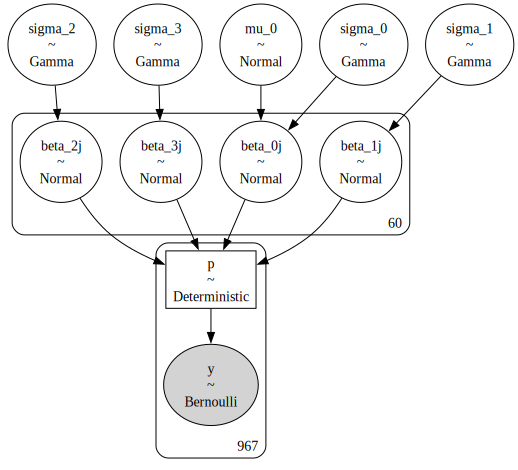

In [28]:
# your code here
pm.model_to_graphviz(varying_coefficients_model)

In [29]:
with varying_coefficients_model:
    trace3 = pm.sample(1000, tune=2000, target_accept=0.95) 
    print(f'DONE')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_0, sigma_0, sigma_1, sigma_2, sigma_3, beta_0j, beta_1j, beta_2j, beta_3j]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 91 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


DONE


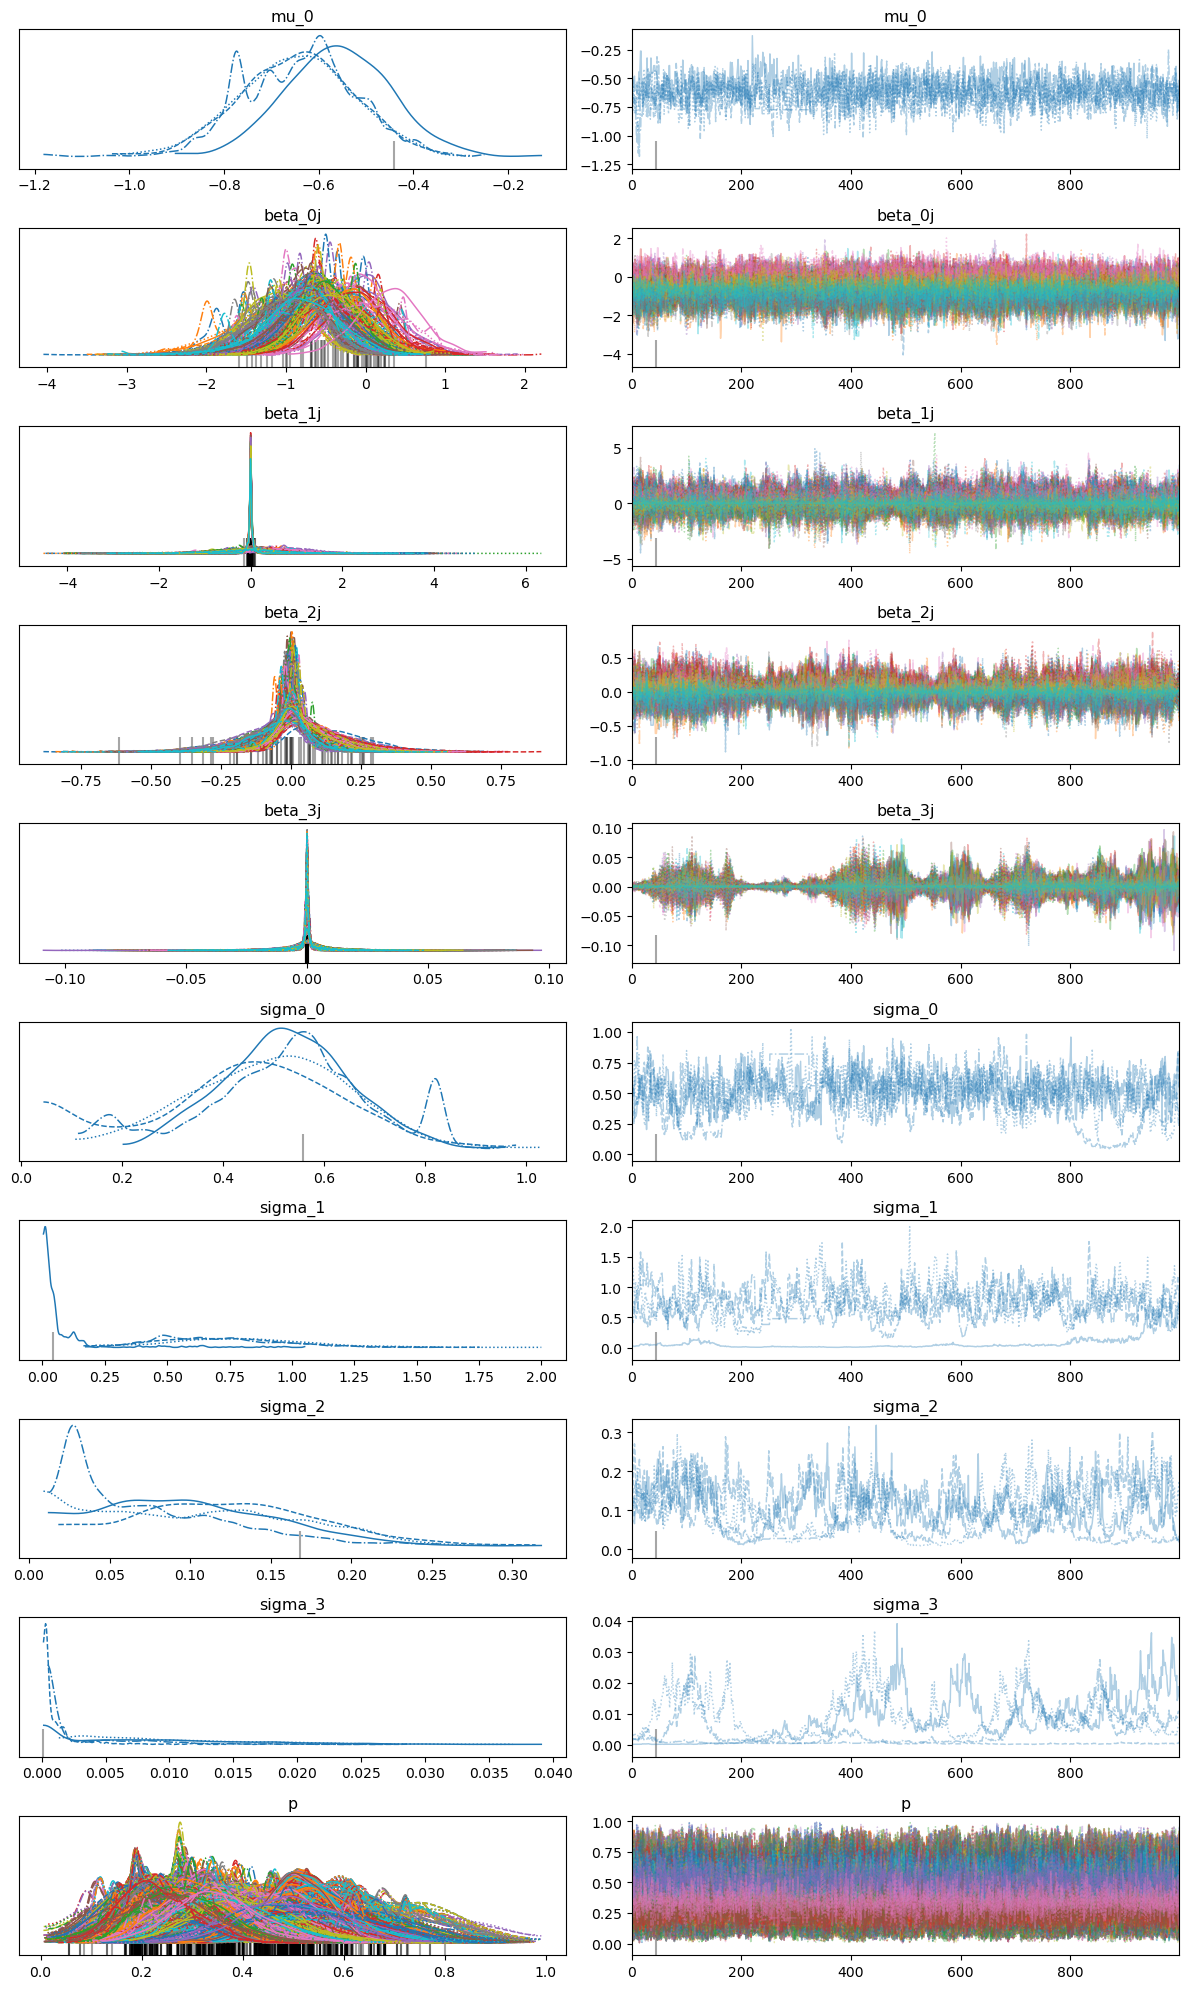

In [30]:
pm.plot_trace(trace3)
plt.tight_layout();

In [31]:
summary_df_3 = pm.summary(trace3)
summary_df_3

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_0       -0.624  0.122  -0.841   -0.390      0.018    0.012      48.0   
beta_0j[0] -1.039  0.453  -1.943   -0.284      0.018    0.013     627.0   
beta_0j[1] -0.901  0.380  -1.565   -0.194      0.031    0.022     142.0   
beta_0j[2] -0.772  0.424  -1.573    0.007      0.019    0.015     569.0   
beta_0j[3] -0.504  0.531  -1.476    0.561      0.020    0.014     640.0   
...           ...    ...     ...      ...        ...      ...       ...   
p[962]      0.277  0.076   0.138    0.418      0.001    0.001    2628.0   
p[963]      0.228  0.069   0.107    0.360      0.002    0.001    1729.0   
p[964]      0.482  0.100   0.301    0.664      0.004    0.003     769.0   
p[965]      0.262  0.086   0.098    0.419      0.002    0.001    2521.0   
p[966]      0.340  0.088   0.180    0.508      0.003    0.002     869.0   

            ess_tail  r_hat  
mu_0           975.0   1.06  
beta_0j[0]    1626.0   1.01  
beta_0j[1]     189.0   1.03  
beta_0j[2]     152.0   1.01  
beta_0j[3]    2685.0   1.01  
...              ...    ...  
p[962]        2416.0   1.00  
p[963]        1962.0   1.00  
p[964]        2577.0   1.01  
p[965]        2386.0   1.00  
p[966]        1603.0   1.01  

[1212 rows x 9 columns]

In [32]:
#SHARE WITH R_HAT > 1.1 (if these are too many,then convergence likely not occurring)
summary_df_3[(summary_df_3['r_hat'] > 1.1)].shape[0]/len(summary_df_3)

0.13036303630363036

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.3 - Distribution of Posterior Means & HDIs</b></div>

Plot the distributions of posterior means and the 95% highest posterior density intervals (HDIs) for the intercepts and coefficients for each district. What do you conclude from these graphs?

**HINT:** The ArviZ [`plot_forest()`](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_forest.html) function is very well-suited for this task.

From these plots, we can see:

- Variability Among Districts: There is considerable variability in the intercepts and slopes among the districts. This suggests that both the baseline rates of contraceptive use (beta_0j) and the effects of the predictors (beta_1j, beta_2j, beta_3j) differ from one district to another.

- Intercepts (beta_0j): The intercepts vary widely, with some districts having negative means (indicating lower contraceptive use) and others positive (indicating higher contraceptive use). The HDIs are also quite wide for some districts, indicating more uncertainty in the estimates.

- Urban Coefficient (beta_1j): The coefficient for the urban variable (beta_1j) shows some variability, suggesting that the influence of living in an urban area on contraceptive use differs between districts.

- Living Children Coefficient (beta_2j): The coefficient for the number of living children (beta_2j) also shows variability across districts. The effect of the number of living children on contraceptive use is not consistent across all districts.

- Age Mean Coefficient (beta_3j): Similarly, the coefficient for the age mean (beta_3j) slightly varies by district, indicating that the effect of a woman's age on contraceptive use is not uniform across the dataset.

Conclusion
The observed variability in the posterior distributions for intercepts and coefficients across districts provides evidence in favor of the varying-coefficients model over a simpler model with fixed coefficients. It suggests that the relationship between the predictors and contraceptive use is complex and influenced by district-specific factors.

The 95% HDIs give an interval within which we can be 95% confident that the true values of the parameters lie, given the data. The fact that these intervals vary significantly in size and location further supports the idea that a one-size-fits-all approach would not be appropriate for this data.

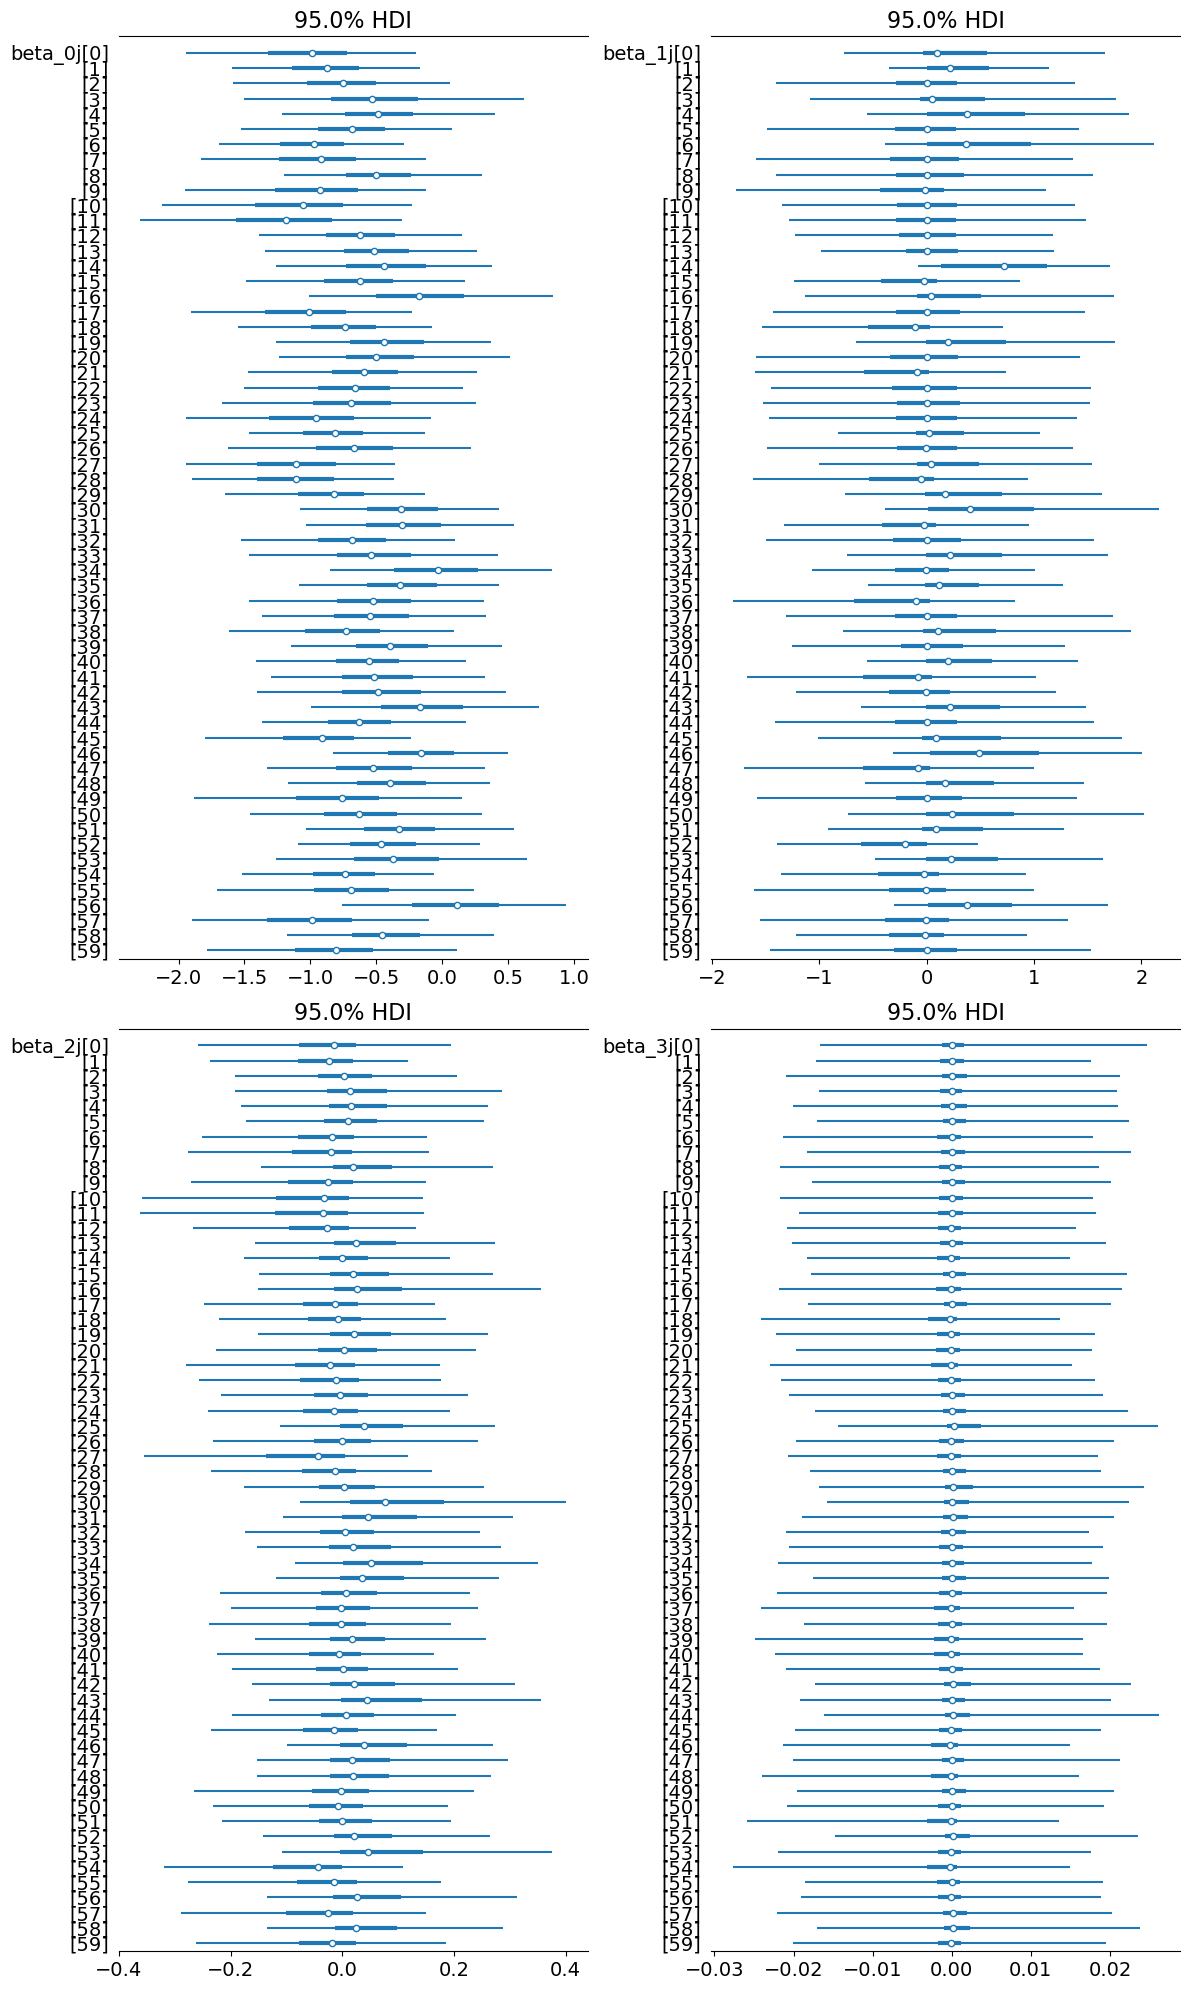

In [33]:
# your code here
fig, axs = plt.subplots(2, 2, figsize=(12, 20))

# Plot for varying intercepts (beta_0j)
az.plot_forest(trace3, var_names=['beta_0j'], ax=axs[0,0], combined=True,
               hdi_prob=0.95, kind='forestplot')

# Plot for varying coefficients for 'urban' (beta_1j)
az.plot_forest(trace3, var_names=['beta_1j'], ax=axs[0,1], combined=True,
               hdi_prob=0.95, kind='forestplot')

# Plot for varying coefficients for 'living.children' (beta_2j)
az.plot_forest(trace3, var_names=['beta_2j'], ax=axs[1,0], combined=True,
               hdi_prob=0.95, kind='forestplot')

# Plot for varying coefficients for 'age_mean' (beta_3j)
az.plot_forest(trace3, var_names=['beta_3j'], ax=axs[1,1], combined=True,
               hdi_prob=0.95, kind='forestplot')

plt.tight_layout()
plt.show()

<!-- END QUESTION -->

<a id="part4"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

## <div class='exercise'>Part 4: Predictions & Model Selection</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.1 - Create and Evaluate Classifiers</b></div>

Build two Bayesian logistic regression classifiers: one from your varying-intercept model (Q2) and another from your varying-coefficients model (Q3). Then, use each model to make predictions on your training and test sets.

* For each of the two classifiers, **on both train and test data separately**, report:
    * percentage of observations predicted to be `1` (i.e., uses contraceptives)
    * accuracy score

Finally, briefly describe the approach you used to implement these classifiers.
  
**Hint:** These classification models will make use of the samples generated by your PyMC models above, but they need not themselves be PyMC model objects. They can also be constructed out of simple Python functions of your own design.

Our approach involves two main steps: prediction and evaluation. 

1) Prediction:

- We utilize the posterior predictive distribution from Bayesian logistic regression models to generate predictions. This is achieved by calculating the average predicted probability of contraceptive use (mean_prob) for each woman in the dataset. The mean_prob is the mean of the probabilities from the posterior distribution of p, which is the expected value of the outcome from your logistic regression model.

- We then compare these mean probabilities against a threshold (defaulted to 0.5) to determine the predicted class. Probabilities above the threshold are classified as 1 (uses contraceptives), and those below as 0 (does not use contraceptives). This threshold-based classification method is a standard approach for binary classification tasks in logistic regression.

2) Evaluation:

- We calculate the percentage of observations predicted to be 1 and the accuracy score for both the training and test sets.
The percentage of observations predicted to be 1 gives us an idea of how many women are predicted to use contraceptives according to this model. This can be compared against the actual distribution of the response variable to check for model bias.

- The accuracy score is a measure of the classifier's performance, representing the proportion of total predictions that were correct. We calculate it by comparing the predicted classes to the actual classes in the dataset.
(Our classifiers are custom Python functions that take the posterior samples (trace) and input features (X) to generate predictions. This approach allows us to directly use the Bayesian model's output for predictive tasks, leveraging the uncertainty captured in the posterior distribution.)


In [34]:
def predict_with_posterior(trace, model, X, threshold=0.5):
    with model:
        # Sample from the posterior predictive distribution
        ppc = pm.sample_posterior_predictive(trace)
        #print(ppc)
    # Compute the mean probability of using contraceptives for each observation
    p_samples = trace2.posterior["p"].values

    mean_prob = np.mean(p_samples, axis=(0, 1))
    
    predictions = (mean_prob >= threshold).astype(int)
    
    return predictions, mean_prob

In [35]:
# Predict with the varying-intercept model
predictions_train_vi, mean_prob_train_vi = predict_with_posterior(trace2, varying_intercept_model2, df_train)
predictions_test_vi, mean_prob_test_vi = predict_with_posterior(trace2, varying_intercept_model2, df_test)

# Predict with the varying-coefficients model
predictions_train_vc, mean_prob_train_vc = predict_with_posterior(trace3, varying_coefficients_model, df_train)
predictions_test_vc, mean_prob_test_vc = predict_with_posterior(trace3, varying_coefficients_model, df_test)


Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


In [36]:
accuracy_train_vi = accuracy_score(df_train['contraceptive_use'], predictions_train_vi)
accuracy_test_vi = accuracy_score(df_test['contraceptive_use'], predictions_test_vi)
percent_1_train_vi = np.mean(predictions_train_vi) * 100
percent_1_test_vi = np.mean(predictions_test_vi) * 100

accuracy_train_vc = accuracy_score(df_train['contraceptive_use'], predictions_train_vc)
accuracy_test_vc = accuracy_score(df_test['contraceptive_use'], predictions_test_vc)
percent_1_train_vc = np.mean(predictions_train_vc) * 100
percent_1_test_vc = np.mean(predictions_test_vc) * 100

In [38]:
print(f"Varying Intercept Model: Training 1s ({percent_1_train_vi}%), Test 1s ({percent_1_test_vi}%), Training Accuracy ({accuracy_train_vi}%), Test Accuracy ({accuracy_test_vi}%)")
print(f"Varying Coeffecient Model: Training 1s ({percent_1_train_vc}%), Test 1s ({percent_1_test_vc}%), Training Accuracy ({accuracy_train_vc}%), Test Accuracy ({accuracy_test_vc}%)")


Varying Intercept Model: Training 1s (22.440537745604964%), Test 1s (22.440537745604964%), Training Accuracy (0.6732161323681489%), Test Accuracy (0.5377456049638056%)
Varying Coeffecient Model: Training 1s (22.440537745604964%), Test 1s (22.440537745604964%), Training Accuracy (0.6732161323681489%), Test Accuracy (0.5377456049638056%)


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.2 - Comparison to Naive Model</b></div>

Report the same four metrics from the previous question for a 3rd, "naive" model that always predicts the most frequent outcome observed in the training data.

In [39]:
# your code here
# Determine the most frequent outcome in the training data
most_frequent_outcome = df_train['contraceptive_use'].mode()

# Predict this outcome for all instances in both the training and test sets
y_pred_train_naive = np.full_like(df_train['contraceptive_use'], fill_value=most_frequent_outcome)
y_pred_test_naive = np.full_like(df_test['contraceptive_use'], fill_value=most_frequent_outcome)

# Calculate the percentage of observations predicted to be '1' for the naive model
percent_1_train_naive = np.mean(y_pred_train_naive) * 100
percent_1_test_naive = np.mean(y_pred_test_naive) * 100

# Calculate the accuracy for the naive model on both the training and test sets
accuracy_train_naive = accuracy_score(df_train['contraceptive_use'], y_pred_train_naive)
accuracy_test_naive = accuracy_score(df_test['contraceptive_use'], y_pred_test_naive)

percent_1_train_naive, percent_1_test_naive, accuracy_train_naive, accuracy_test_naive

(0.0, 0.0, 0.610134436401241, 0.6049638055842813)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.3 - Model Selection</b></div>

What do you conclude from the results of 4.1 & 4.2? Which model appears to be the best (i.e. varying-intercept, varying-coefficient, or naive), and what is your rationale?

Based on the results from 4.1 and 4.2, we can draw the following conclusions regarding the performance of the varying-intercept, varying-coefficient, and naive models:

- Varying-Intercept Model: This model showed an accuracy of approximately 67.32% on the training data and 53.77% on the test data. About 22.44% of observations were predicted to be class 1 (uses contraceptives) for both training and test sets.

- Varying-Coefficient Model: Interestingly, this model yielded exactly the same metrics as the varying-intercept model. This could suggest that the varying coefficients may not have contributed additional predictive power beyond the varying intercepts within this dataset, or it could be an indication of a potential error. (CHECK!)

- Naive Model: The naive model, which always predicts the most frequent outcome observed in the training data, showed an accuracy of approximately 61.01% on the training data and 60.50% on the test data. This model predicted 0% of observations to be class 1, which is expected as it always predicts the most common class.

Given these results, the varying-intercept and varying-coefficient models outperform the naive model in terms of accuracy on the training data. However, the accuracy drops on the test data for both models, which may indicate some overfitting to the training data. Despite this, they still maintain better predictive performance than the naive model

Assuming the results reported are accurate, the varying-intercept model might be considered the best among the three due to its simplicity and slightly better generalization to the test data compared to the naive model.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.4 Wrap-up</b></div>

* In a few sentences, please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation.

* How many hours did you spend working on this assignment? Store this as an int or float in `time_spent_on_hw`

It was an interesting assignment, though the guidance was lighter than usual. The repeated nature of the code was helpful but we spent a lot of time wondering whether we are heading in the right direction.

In [40]:
time_spent_on_hw = 6

In [41]:
grader.check("q4.4")

q4.4 results: All test cases passed!

<!-- END QUESTION -->



In [36]:
time_end = time.time()
print(f"It took {(time_end - time_start)/60:.2f} minutes for this notebook to run")

It took 5.87 minutes for this notebook to run


**This concludes HW2. Thank you!**